# Appendix B: Level 2 Filters

#### After applying the first level of filters, we continue with the four "level 2" filters detailed below:

* `“Days to Maturity <7 or >180” Filter:` We remove all options with fewer than
seven or more than 180 calendar days to expiration. The short maturity options tend to move erratically close to expiration and the long maturity options lack volume and open interest.
“IV<5% or >100%” Filter: We remove all option quotes with implied volatilities lower than 5% or higher than 100%, computed using T-bill interest
rates. Such extreme values likely indicate quotation problems or simply low
value.

* `“Moneyness <0.8 or >1.2” Filter:` We remove all option quotes with moneyness, the ratio of strike price to index price, below 0.8 or above 1.2. These
options have little value beyond their intrinsic value and are also very thinly
traded.

* `“Implied Interest Rate <0” Filter:` When filtering outliers, we use T-bill interest rates to compute implied volatilities. T-bill interest rates are obtained from
the Federal Reserve’s H.15 release. We assign a T-bill rate to each observation
by assuming that we can use the next shortest rate if the time to expiration of
the option is shorter than the shortest constant maturity rate.
Our goal is to obtain an interest rate that is as close as possible to the one
faced by investors in the options market. It appears that the T-bill rates are
not the relevant ones when pricing these options. Specifically, when the T-bill
rates are used, put and call implied volatilities do not line up very well; for
example, the T-bill rate tends to be too high for short maturity options, perhaps because no T-bill has maturity of less than a month. To address these
issues, we compute a put-call parity-implied interest rate. Since we believe that
put-call parity holds reasonably well in this deep and liquid European options
market, we use the put-call parity-implied interest rate as our interest rate in
the remainder of the paper and for further filters.
To construct this rate, we take all put-call pairs of a given maturity and
impose put-call parity using the bid-ask midpoint as the price, and allowing
the interest rate to adjust. We remove 89,563 pairs with a negative implied
interest rate. We then take the median-implied interest rate across all remaining pairs of the same maturity with moneyness between 0.95 and 1.05 and
assign it to all quotes with that maturity. We are able to directly assign an
implied interest rate to 93% of our sample in this way. We fill in the gaps by
interpolating across maturities and if necessary, across days. Our implied
interest rate is on average 54 bps above the T-bill rate

* `“Unable to Compute IV” Filter:` We remove quotes that imply negative time
value.


In [105]:
import sys
sys.path.insert(1, '../src/')
import pandas as pd
import numpy as np
import config
from pathlib import Path 
import time 
import matplotlib.pyplot as plt
import random

import load_option_data_01 as l1
import filter_option_data_01 as f1
import filter_option_data_02 as f2
import filter_option_data_03 as f3

OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)
WRDS_USERNAME = config.WRDS_USERNAME

START_DATE_01 =config.START_DATE_01
END_DATE_01 = config.END_DATE_01

In [106]:
# load data with level 1 filters applied
optm_l1_df = pd.read_parquet(DATA_DIR / "intermediate" / "data_1996-01_2012-01_L1filter.parquet")

## “Days to Maturity <7 or >180” Filter

In [107]:
# calculate time to maturity in years for level 1 data
optm_l1_df['time_to_maturity_yrs'] = f2.calc_time_to_maturity_yrs(optm_l1_df)

# create data frame with initial level 2 filter for time to maturity applied
optm_l2_df = f2.filter_time_to_maturity(optm_l1_df)

#### Distribution of time to maturity, measured in years from option initial date to expiration date. Left shows the distribution prior to applying the initial level 2 filter of excluding days to maturity less than 7 and greater than 180. Right shows distribution post filter. 

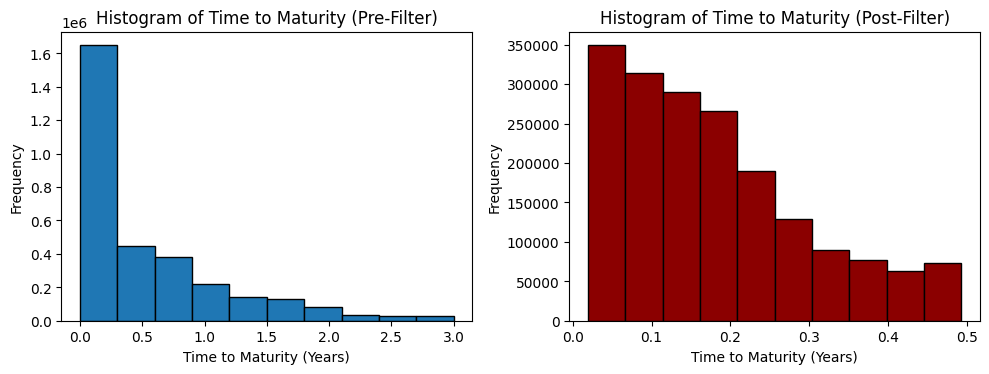

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting histogram for optm_l1_df
axes[0].hist(optm_l1_df['time_to_maturity_yrs'], bins=10, edgecolor='black')
axes[0].set_xlabel('Time to Maturity (Years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Time to Maturity (Pre-Filter)')

# Plotting histogram for optm_l2_df
axes[1].hist(optm_l2_df['time_to_maturity_yrs'], bins=10, edgecolor='black', color='darkred')
axes[1].set_xlabel('Time to Maturity (Years)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Time to Maturity (Post-Filter)')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### As noted in the paper, the short maturity options tend to move erratically close to expiration. In the graph below, post filter we see a slight reduction of short term options with a high implied volatility.

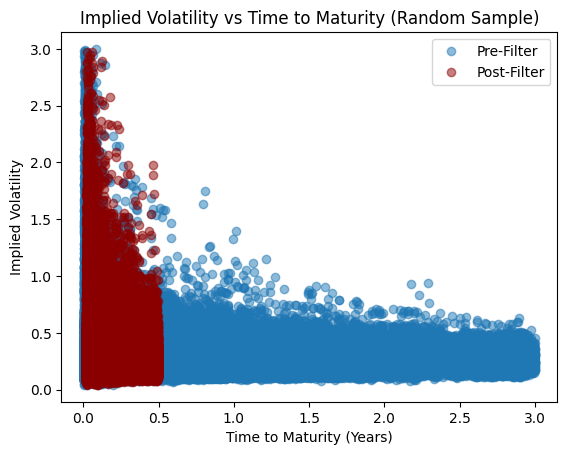

In [109]:
sample_size = 200000  # Adjust as needed
sample_ind_l1 = random.sample(range(len(optm_l1_df)), min(sample_size, len(optm_l1_df)))
sample_ind_l2 = random.sample(range(len(optm_l2_df)), min(sample_size, len(optm_l2_df)))

plt.plot(optm_l1_df.iloc[sample_ind_l1]['time_to_maturity_yrs'], optm_l1_df.iloc[sample_ind_l1]['impl_volatility'], 'o', alpha=0.5, label='Pre-Filter')
plt.plot(optm_l2_df.iloc[sample_ind_l2]['time_to_maturity_yrs'], optm_l2_df.iloc[sample_ind_l2]['impl_volatility'], 'o', alpha=0.5, label='Post-Filter', color='darkred')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Time to Maturity (Random Sample)')
plt.legend()
plt.show()

#### Also noted in the paper, the long maturity options lack volume and open interest. On the right (in red), the filter has a smoothing affect on the distribution of volumn and open interest.

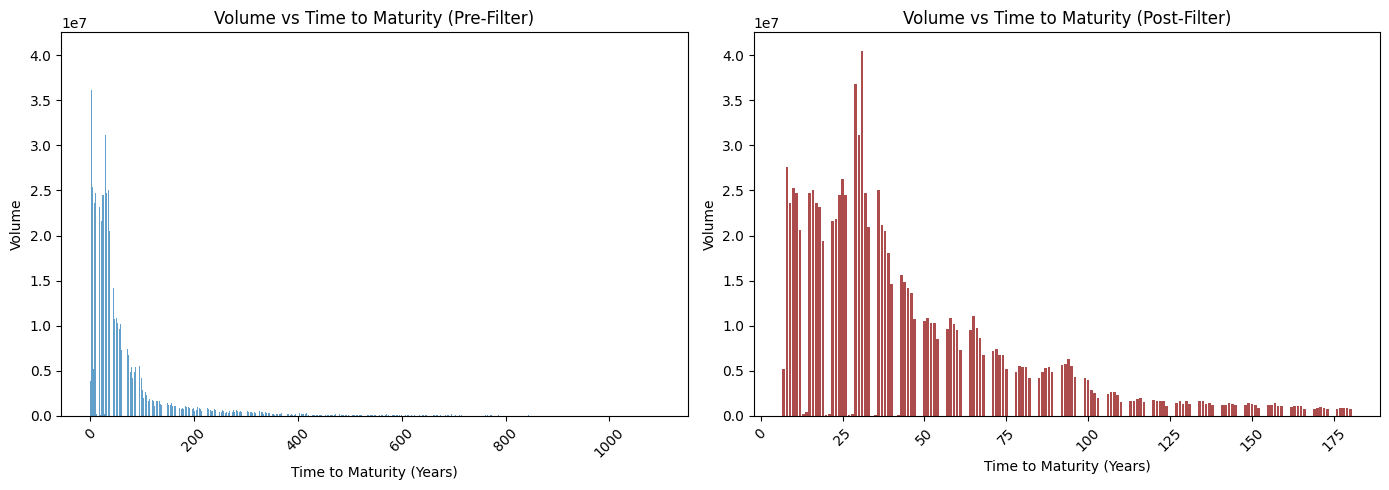

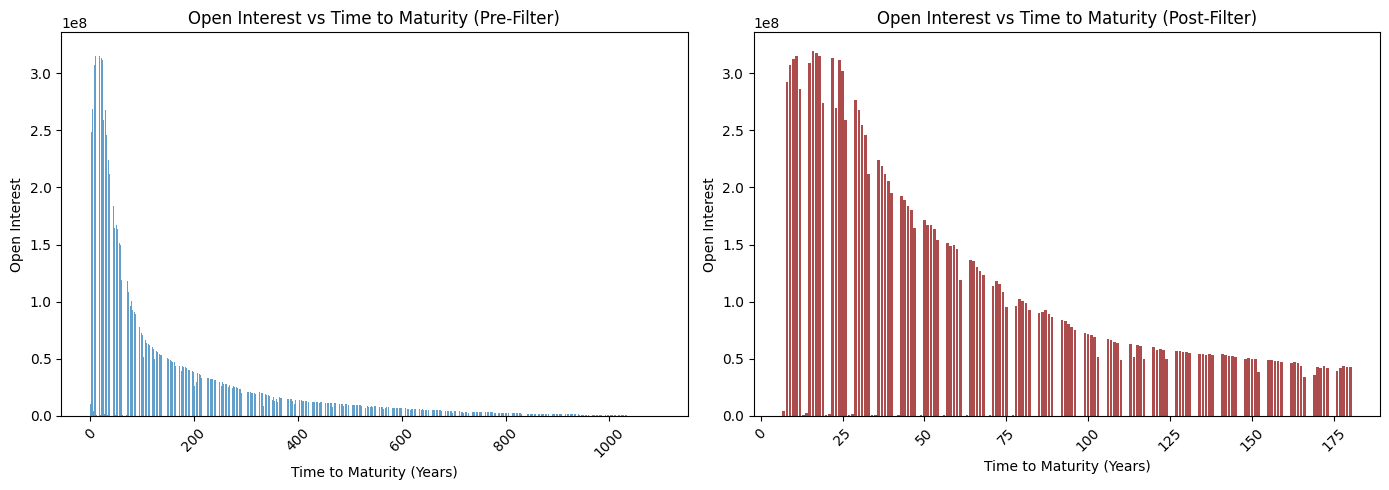

In [110]:
vol_ttm_1 = optm_l1_df.groupby('time_to_maturity')['volume'].sum().reset_index()
vol_ttm_2 = optm_l2_df.groupby('time_to_maturity')['volume'].sum().reset_index()
int_ttm_1 = optm_l1_df.groupby('time_to_maturity')['open_interest'].sum().reset_index()
int_ttm_2 = optm_l2_df.groupby('time_to_maturity')['open_interest'].sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plotting volume for optm_l1_df as a bar graph
axes[0].bar(vol_ttm_1['time_to_maturity'], vol_ttm_1['volume'], alpha=0.7)
axes[0].set_xlabel('Time to Maturity (Years)')
axes[0].set_ylabel('Volume')
axes[0].set_title('Volume vs Time to Maturity (Pre-Filter)')

# Plotting volume for optm_l2_df as a bar graph
axes[1].bar(vol_ttm_2['time_to_maturity'], vol_ttm_2['volume'], color='darkred', alpha=0.7)
axes[1].set_xlabel('Time to Maturity (Years)')
axes[1].set_ylabel('Volume')
axes[1].set_title('Volume vs Time to Maturity (Post-Filter)')

# Rotating x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plotting volume for optm_l1_df as a bar graph
axes[0].bar(int_ttm_1['time_to_maturity'], int_ttm_1['open_interest'], alpha=0.7)
axes[0].set_xlabel('Time to Maturity (Years)')
axes[0].set_ylabel('Open Interest')
axes[0].set_title('Open Interest vs Time to Maturity (Pre-Filter)')

# Plotting volume for optm_l2_df as a bar graph
axes[1].bar(int_ttm_2['time_to_maturity'], int_ttm_2['open_interest'], color='darkred', alpha=0.7)
axes[1].set_xlabel('Time to Maturity (Years)')
axes[1].set_ylabel('Open Interest')
axes[1].set_title('Open Interest vs Time to Maturity (Post-Filter)')

# Rotating x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## “IV<5% or >100%” Filter

In [111]:
optm_l2_iv = f2.filter_iv(optm_l2_df)

#### As shown below removing option quotes w/ implied volatilities lower than 5% or higher than 100% removes extreme values and reduces the skewness of the implied volatility distribution.

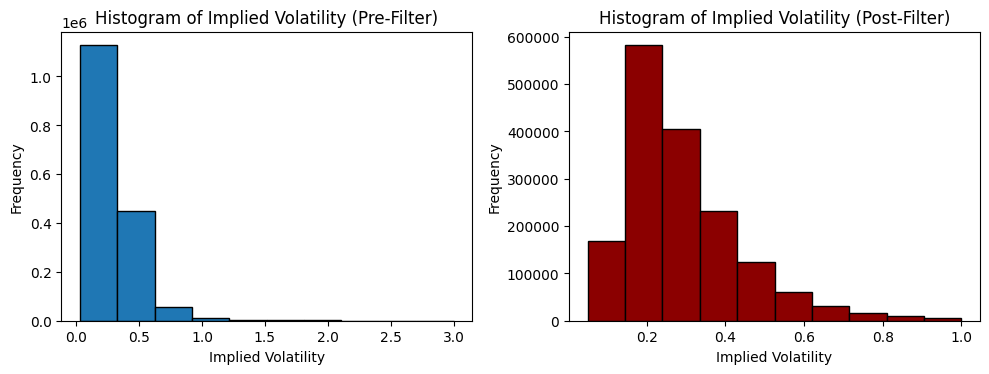

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting histogram for optm_l2_df
axes[0].hist(optm_l2_df['impl_volatility'], bins=10, edgecolor='black')
axes[0].set_xlabel('Implied Volatility')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Implied Volatility (Pre-Filter)')

# Plotting histogram for optm_l1_iv
axes[1].hist(optm_l2_iv['impl_volatility'], bins=10, edgecolor='black', color='darkred')
axes[1].set_xlabel('Implied Volatility')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Implied Volatility (Post-Filter)')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

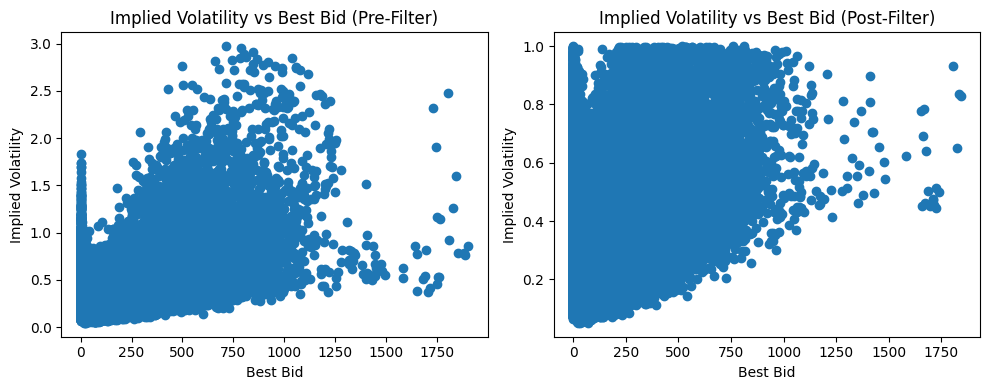

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sample_size = 200000  # Adjust as needed
sample_ind_iv = random.sample(range(len(optm_l2_iv)), min(sample_size, len(optm_l2_iv)))
sample_ind = random.sample(range(len(optm_l2_df)), min(sample_size, len(optm_l2_df)))


# Plotting optm_l2_df
axes[0].scatter(optm_l2_df.iloc[sample_ind]['best_bid'], optm_l2_df.iloc[sample_ind]['impl_volatility'])
axes[0].set_xlabel('Best Bid')
axes[0].set_ylabel('Implied Volatility')
axes[0].set_title('Implied Volatility vs Best Bid (Pre-Filter)')

# Plotting optm_l2_iv
axes[1].scatter(optm_l2_iv.iloc[sample_ind_iv]['best_bid'], optm_l2_iv.iloc[sample_ind_iv]['impl_volatility'])
axes[1].set_xlabel('Best Bid')
axes[1].set_ylabel('Implied Volatility')
axes[1].set_title('Implied Volatility vs Best Bid (Post-Filter)')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## “Moneyness <0.8 or >1.2” Filter

In [114]:
optm_l2_mny = f2.filter_moneyness(optm_l2_iv)

#### Removing option quotes with moneyness lower than 0.8 and higher than 1.2 eliminates extreme values. These extreme values potentially have quotation problems or low values. 

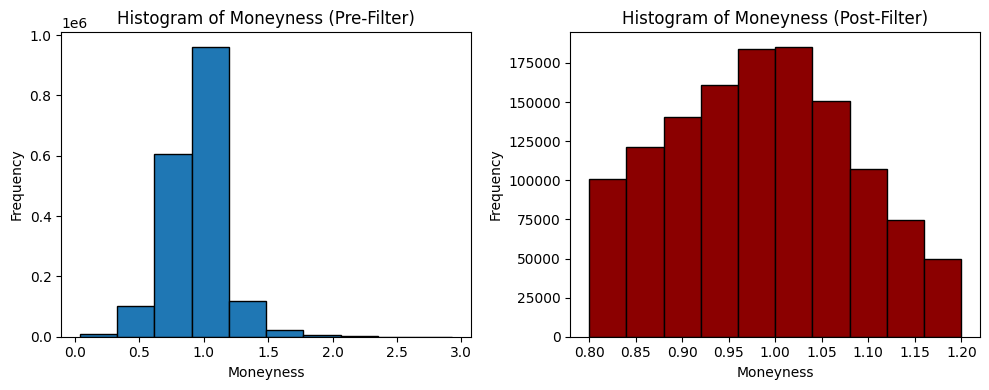

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting histogram for optm_l2_iv
axes[0].hist(optm_l2_iv['mnyns'], bins=10, edgecolor='black')
axes[0].set_xlabel('Moneyness')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Moneyness (Pre-Filter)')

# Plotting histogram for optm_l2_mny
axes[1].hist(optm_l2_mny['mnyns'], bins=10, edgecolor='black', color='darkred')
axes[1].set_xlabel('Moneyness')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Moneyness (Post-Filter)')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


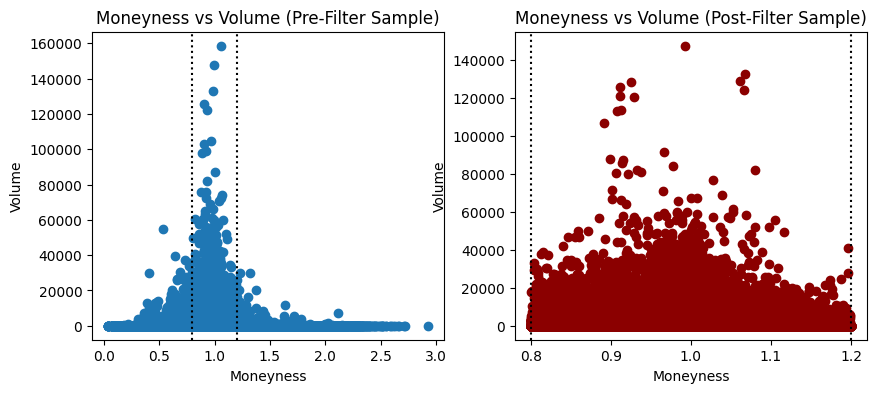

In [116]:
sample_size = 200000  # Adjust as needed
sample_ind_iv = random.sample(range(len(optm_l2_iv)), min(sample_size, len(optm_l2_iv)))
sample_ind_mny = random.sample(range(len(optm_l2_mny)), min(sample_size, len(optm_l2_mny)))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting optm_l2_iv
axes[0].scatter(optm_l2_iv.iloc[sample_ind_iv]['mnyns'], optm_l2_iv.iloc[sample_ind_iv]['volume'])
axes[0].set_xlabel('Moneyness')
axes[0].set_ylabel('Volume')
axes[0].set_title('Moneyness vs Volume (Pre-Filter Sample)')

# Plotting optm_l2_mny
axes[1].scatter(optm_l2_mny.iloc[sample_ind_mny]['mnyns'], optm_l2_mny.iloc[sample_ind_mny]['volume'], color='darkred')
axes[1].set_xlabel('Moneyness')
axes[1].set_ylabel('Volume')
axes[1].set_title('Moneyness vs Volume (Post-Filter Sample)')

# Add dotted line representing the range 0.8 to 1.2 on x-axis
axes[0].axvline(0.8, color='black', linestyle='dotted')
axes[0].axvline(1.2, color='black', linestyle='dotted')
axes[1].axvline(0.8, color='black', linestyle='dotted')
axes[1].axvline(1.2, color='black', linestyle='dotted')

# Show the plot
plt.show()

## “Implied Interest Rate <0” Filter

#### In order to calculate an interest rate close as possible to what is faced by investors in the options market, we compute a put-call parity-implied interest rate.

#### To contruct this rate we take all put-call pairs of given maturity and impose put-call parity using bid-ask midpoint as the price and allowing interest rate to adjust.We then take the median-implied interest rate across all remaining pairs of the same maturity with moneyness between 0.95 and 1.05 and assign it to all quotes with that maturity.

#### Through this process the authors were able to directly assign an implied interest rate to 93% of the sample. We were able to achieve a similar number of 94%. However, in the paper, they removed 89,563 pairs with a negative implied interest rate while we removed 293,363 pairs.

In [117]:
optm_l2_int = f2.filter_implied_interest_rate(optm_l2_mny)

 |-- PCP filter: Check ok --> Underlying prices, strike prices of put and call options match exactly.


#### The authors implied interest rate was on average 54 bps above the T-bill rate. However, as shown below our calculate implied interest rate has a lower distribution than the T-bill rates.

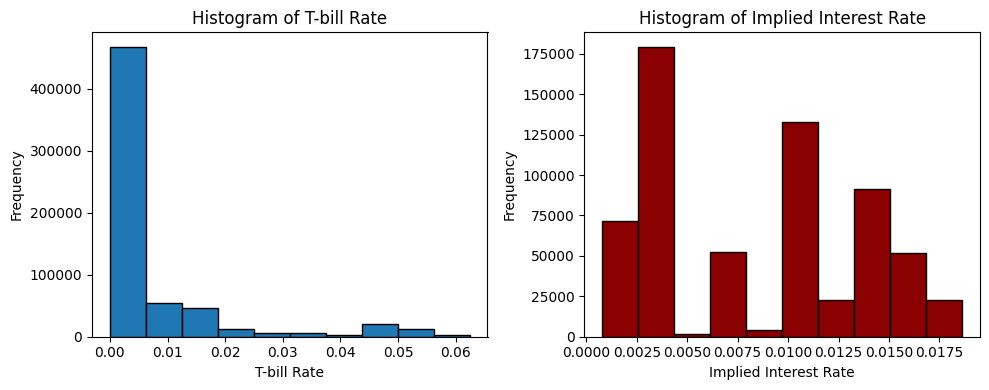

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting histogram for impl_int_rate
axes[1].hist(optm_l2_int['pc_parity_int_rate'], bins=10, edgecolor='black',color='darkred')
axes[1].set_xlabel('Implied Interest Rate')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Implied Interest Rate')

# Plotting histogram for tb_m3
axes[0].hist(optm_l2_int['tb_m3'], bins=10, edgecolor='black')
axes[0].set_xlabel('T-bill Rate')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of T-bill Rate')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


#### Through this process the authors were able to directly assign an implied interest rate to 9% of the sample. 

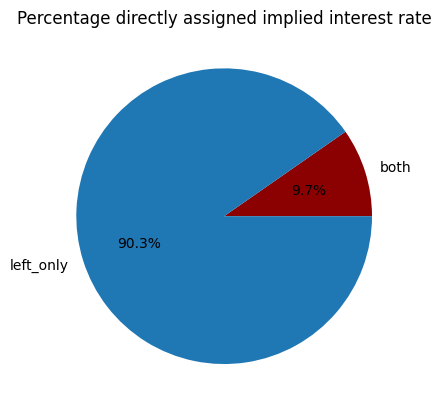

In [119]:
# Calculate the percentage
percentage_both = optm_l2_int['_merge'].value_counts(normalize=True)['both'] * 100
percentage_left_only = optm_l2_int['_merge'].value_counts(normalize=True)['left_only'] * 100

# Create a dataframe for plotting
df_percentage = pd.DataFrame({'Percentage': [percentage_both, percentage_left_only]}, index=['both', 'left_only'])

# Plot the dataframe as a pie chart
df_percentage.plot(kind='pie', y='Percentage', legend=False, autopct='%1.1f%%', colors=['darkred','C0'])
plt.ylabel('')
plt.title('Percentage directly assigned implied interest rate')

# Show the chart
plt.show()

## "Unable to Compute IV" Filter

Through our analysis we found there are cases where we could not compute implied volatility (IV), as a result, the values were NaN. In the graph below, there is a clear trend where the percentage of incomputable IVs increase as time to maturity decreases.

In [120]:
optm_l2_univ = f2.filter_unable_compute_iv(optm_l2_int)

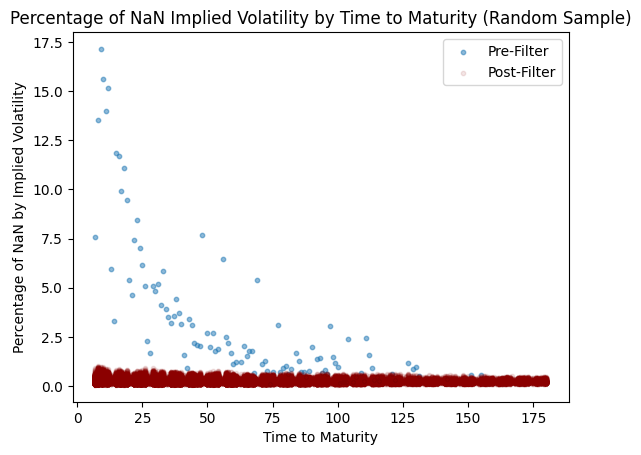

In [121]:
sample_size = 100000  # Adjust as needed
sample_ind_univ = random.sample(range(len(optm_l2_univ)), min(sample_size, len(optm_l2_univ)))
size_x = optm_l2_univ.shape[0]/sample_size

nan_percentage = (optm_l2_int.iloc[sample_ind_univ].loc[optm_l2_int['impl_volatility'].isna()].groupby(['time_to_maturity']).size())/(optm_l2_int.iloc[sample_ind_univ].groupby(['time_to_maturity']).size())*100

plt.clf()
plt.scatter(nan_percentage.index, nan_percentage, alpha=0.5, s=10, label='Pre-Filter')
plt.scatter(optm_l2_univ.iloc[sample_ind_univ]['time_to_maturity'], optm_l2_univ.iloc[sample_ind_univ]['impl_volatility'], color='darkred', alpha=0.1, s=10, label='Post-Filter')
plt.xlabel('Time to Maturity')
plt.ylabel('Percentage of NaN by Implied Volatility')
plt.title('Percentage of NaN Implied Volatility by Time to Maturity (Random Sample)')
plt.legend()
plt.show()

## Filters Table through L2

In [122]:
# Create a list of dataframes and their corresponding names
l1_filters_df = pd.DataFrame([
    {'Level 1 filters': 'All', 'Remaining': optm_l1_df.shape[0]},
])

l2_filter_dfs = pd.DataFrame([
    {'Level 2 filters': 'Days to expiration <7 or >180', 'Deleted': optm_l1_df.shape[0]-optm_l2_df.shape[0]},
    {'Level 2 filters': 'IV <5% or >100%', 'Deleted': optm_l2_df.shape[0]-optm_l2_iv.shape[0]},
    {'Level 2 filters': 'K/S <0.8 or >1.2', 'Deleted': optm_l2_iv.shape[0]-optm_l2_mny.shape[0]},
    {'Level 2 filters': 'Implied interest rate <0', 'Deleted': optm_l2_mny.shape[0]-optm_l2_int.shape[0]},
    {'Level 2 filters': 'Unable to compute IV', 'Deleted': optm_l2_int.shape[0]-optm_l2_univ.shape[0]},
    {'Level 2 filters': 'All', 'Remaining': optm_l2_univ.shape[0]}
])


# Set the 'Level 2 filters' column as the index
l1_filters_df.set_index('Level 1 filters', inplace=True)
l2_filter_dfs.set_index('Level 2 filters', inplace=True)

table_b1_df = pd.concat([l1_filters_df, l2_filter_dfs], 
                        keys=['Level 1 filters', 'Level 2 filters'])
table_b1_df = table_b1_df[['Deleted', 'Remaining']]
table_b1_df['Deleted'] = table_b1_df['Deleted'].map('{:,.0f}'.format)
table_b1_df['Remaining'] = table_b1_df['Remaining'].map('{:,.0f}'.format)
table_b1_df = table_b1_df.map(lambda x: '' if str(x).lower() == 'nan' else x)
table_b1_df

Deleted  Remaining
Level 1 filters All                                       3,138,492
Level 2 filters Days to expiration <7 or >180  1,297,729           
                IV <5% or >100%                   16,432           
                K/S <0.8 or >1.2                 550,227           
                Implied interest rate <0         642,940           
                Unable to compute IV              37,733           
                All                                         593,431